In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt

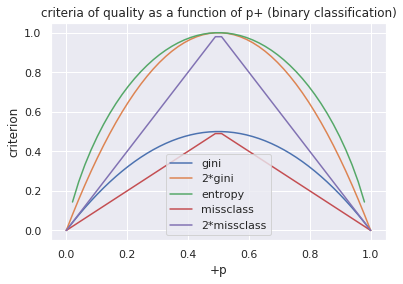

In [2]:
plt.figure(figsize = (6,4))
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1 - x) for x in xx], label = 'gini')
plt.plot(xx, [4 * x * (1 - x) for x in xx], label = '2*gini')
plt.plot(xx, [-x * np.log2(x) - (1 - x) * np.log2(1-x) for x in xx], label = 'entropy')
plt.plot(xx, [1 - max(x,1-x) for x in xx], label = 'missclass')
plt.plot(xx, [2 - 2 * max(x,1-x) for x in xx], label = '2*missclass')
plt.xlabel('+p')
plt.ylabel('criterion')
plt.title('criteria of quality as a function of p+ (binary classification)')
plt.legend();


#### Example
Let's consider fitting a decision tree to some synthetic data. We will generate samples from two classes, both normal distributions but with different means.

In [3]:
#First class
np.random.seed(17)
train_data = np.random.normal(size = (100,2))
train_labels = np.zeros(100)

#adding second class
#We use np.r_ to concatenate the classes
train_data = np.r_[train_data, np.random.normal(size = (100,2), loc = 2)]
train_labels = np.r_[train_labels, np.ones(100)]

Let's plot the data. Informally, the classification problem in this case is to build some "good" boundary separating the two classes (the red dots from the yellow). Machine learning for this case boils down to choosing a good separating border. A straight line will be too simple while some complex curve snaking by each red dot will be too complex and will lead us to making mistakes on new samples. Intuitively, some smooth boundary, or at least a straight line or a hyperplane, would work well on new data.

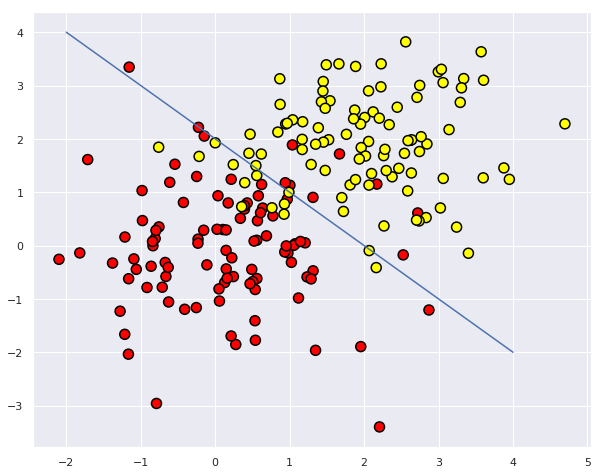

In [4]:
plt.figure(figsize = (10,8))
plt.scatter(train_data[:,0], train_data[:,1], c = train_labels, s = 100, cmap = 'autumn', edgecolors = 'black', linewidth = 1.5);
plt.plot(range(-2,5), range(4,-3,-1));

Let's try to separate these two classes by training an Sklearn decision tree. We will use max_depth parameter that limits the depth of the tree. Let's visualize the resulting separating boundary.

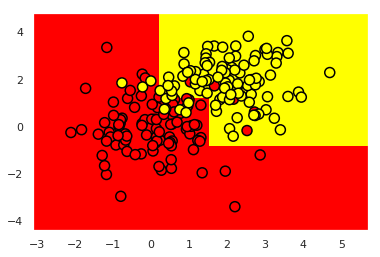

In [5]:
from sklearn.tree import DecisionTreeClassifier

#Let's write an auxiliary function that will return grid for turther visualization
def get_grid(data):
    x_min, x_max = data[:, 0].min() -  1, data[:, 0].max()+1
    y_min, y_max = data[:, 1].min() -  1, data[:, 1].max()+1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

clf_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 17)

#training the tree
clf_tree.fit(train_data, train_labels)

#some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx, yy, predicted, cmap = 'autumn')

plt.scatter(train_data[:,0], train_data[:,1], c = train_labels, s = 100, cmap = 'autumn', edgecolors = 'black', linewidth = 1.5);


And how does the tree itself look? We see that the tree "cuts" the space into 8 rectangles, i.e. the tree has 8 leaves. Within each rectangle, the tree will make the prediction according to the majority label of the objects inside it.

In [6]:
import pydotplus 
from sklearn.tree import export_graphviz
def tree_graph_to_png(tree,feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names = feature_names, filled = True, out_file = None)
    graph= pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)


In [7]:
tree_graph_to_png(tree = clf_tree, feature_names = ['x1', 'x2'], png_file_to_save = '../03_Decision_Trees/topic3_tree1.png')


#### How can we "read" such a tree?

In the beginning, there were 200 samples (instances), 100 of each class. The entropy of the initial state was maximal, $S=1$. Then, the first partition of the samples into 2 groups was made by comparing the value of $x_{2}$ with $1.211$ (find this part of the border in the picture above). With that, the entropy of both left and right groups decreased. The process continues up to depth 3. In this visualization, the more samples of the first class, the darker the orange color of the vertex; the more samples of the second class, the darker the blue. At the beginning, the number of samples from two classes is equal, so the root node of the tree is white.

### How a Decision Tree Works with Numerical Features

Suppose we have a numeric feature "Age" that has a lot of unique values. A decision tree will look for the best (according to some criterion of information gain) split by checking binary attributes such as "Age <17", "Age < 22.87", and so on. But what if the age range is large? Or what if another quantitative variable, "salary", can also be "cut" in many ways? There will be too many binary attributes to select from at each step during tree construction. To resolve this problem, heuristics are usually used to limit the number of thresholds to which we compare the quantitative variable.

Let's consider an example. Suppose we have the following dataset:

In [8]:
data = pd.DataFrame({'Age': [17,64,18,20,38,49,55,25,29,31,33], 
             'Loan_Default': [1,0,1,0,1,0,0,1,1,0,1]})
data

Age  Loan_Default
0    17             1
1    64             0
2    18             1
3    20             0
4    38             1
5    49             0
6    55             0
7    25             1
8    29             1
9    31             0
10   33             1

Let's sort it by age in ascending order.

In [9]:
age_tree = DecisionTreeClassifier(random_state = 17)
age_tree.fit(data['Age'].values.reshape(-1, 1), data['Loan_Default'].values)

tree_graph_to_png(age_tree, feature_names = ['Age'], png_file_to_save = '../03_Decision_Trees/topic3_tree2.png' )

We see that the tree used the following 5 values to evaluate by age: 43.5, 19, 22.5, 30, and 32 years. If you look closely, these are exactly the mean values between the ages at which the target class "switches" from 1 to 0 or 0 to 1. To illustrate further, 43.5 is the average of 38 and 49 years; a 38-year-old customer failed to return the loan whereas the 49-year-old didn't. The tree looks for the values at which the target class switches its value as a threshold for "cutting" a quantitative variable.

Given this information, why do you think it makes no sense here to consider a feature like "Age <17.5"?

Let's consider a more complex example by adding the "Salary" variable (in the thousands of dollars per year).


In [10]:
data2 = pd.DataFrame({'Age':  [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33], 
                      'Salary': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88], 
                      'Loan_Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data2

Age  Loan_Default  Salary
0    17             1      25
1    64             0      80
2    18             1      22
3    20             0      36
4    38             1      37
5    49             0      59
6    55             0      74
7    25             1      70
8    29             1      33
9    31             0     102
10   33             1      88

If we sort by age, the target class ( "loan default") switches (from 1 to 0 or vice versa) 5 times. And if we sort by salary, it switches 7 times. How will the tree choose features now? Let's see.

In [11]:
age_sal_tree = DecisionTreeClassifier(random_state = 17)
age_sal_tree.fit(data2[['Age', 'Salary']].values, data2['Loan_Default'].values);

In [12]:
tree_graph_to_png(tree = age_sal_tree, feature_names = ['Age', 'Salary'], png_file_to_save= '../03_Decision_Trees/topic3_tree3.png')

We see that the tree partitioned by both salary and age. Moreover, the thresholds for feature comparisons are 43.5 and 22.5 years of age and 95k and 30.5k per year. Again, we see that 95 is the average between 88 and 102; the individual with a salary of 88k proved to be "bad" while the one with 102k was "good". The same goes for 30.5k. That is, only a few values for comparisons by age and salary were searched. Why did the tree choose these features? Because they gave better partitioning (according to Gini uncertainty).

**conclusion:** the simplest heuristics for handling numeric features in a decision tree is to sort its values in ascending order and check only those thresholds where the value of the target variable changes.

Furthermore, when there are a lot of numeric features in a dataset, each with a lot of unique values, only the top-N of the thresholds described above are selected, i.e. only use the top-N that give maximum gain. The process is to construct a tree of depth 1, compute the entropy (or Gini uncertainty), and select the best thresholds for comparison.

To illustrate, if we split by "Salary ≤ 34.5", the left subgroup will have an entropy of 0 (all clients are "bad"), and the right one will have an entropy of 0.954 (3 "bad" and 5 "good", you can check this yourself as it will be part of the assignment). The information gain is roughly 0.3. If we split by "Salary ≤ 95", the left subgroup will have the entropy of 0.97 (6 "bad" and 4 "good"), and the right one will have the entropy of 0 (a group containing only one object). The information gain is about 0.11. If we calculate information gain for each partition in that manner, we can select the thresholds for comparison of each numeric feature before the construction of a large tree (using all features).

More examples of numeric feature discretization can be found in posts like ["A Simple Guide to Entropy-Based Discretization"](http://kevinmeurer.com/a-simple-guide-to-entropy-based-discretization/) or ["Discretizing a continuous variable using Entropy"](http://clear-lines.com/blog/post/Discretizing-a-continuous-variable-using-Entropy.aspx). One of the most prominent scientific papers on this subject is "On the handling of continuous-valued attributes in decision tree generation" (UM Fayyad. KB Irani, "Machine Learning", 1992)

### Crucial Tree Parameters

Technically, you can build a decision tree until each leaf has exactly one instance, but this is not common in practice when building a single tree because it will be overfitted, or too tuned to the training set, and will not predict labels for new data well. At the bottom of the tree, at some great depth, there will be partitions on less important features (e.g. whether a client came from Leeds or New York). We can exaggerate this story further and find that all four clients who came to the bank for a loan in green trousers did not return the loan. Even if that were true in training, we do not want our classification model to generate such specific rules.

There are two exceptions where the trees are built to the maximum depth:

- Random Forest (a group of trees) averages the responses from individual trees that are built to the maximum depth (we will talk later on why you should do this)
- Pruning trees. In this approach, the tree is first constructed to the maximum depth. Then, from the bottom up, some nodes of the tree are removed by comparing the quality of the tree with and without that partition (comparison is performed using cross-validation, more on this below).

The picture below is an example of a dividing border built in an overfitted tree.




The most common ways to deal with overfitting in decision trees are as follows:

- artificial limitation of the depth or a minimum number of samples in the leaves: the construction of a tree just stops at some point;
- pruning the tree.




### Class DecisionTreeClassifier in Scikit-learn

The main parameters of the sklearn.tree.DecisionTreeClassifier class are:

- max_depth – the maximum depth of the tree;
- max_features - the maximum number of features with which to search for the best partition (this is necessary with a large number of features because it would be "expensive" to search for partitions for all features);
- min_samples_leaf – the minimum number of samples in a leaf. This parameter prevents creating trees where any leaf would have only a few members.

The parameters of the tree need to be set depending on input data, and it is usually done by means of cross-validation, more on this below.

### Decision Tree in a Regression Problem

When predicting a numeric variable, the idea of a tree construction remains the same, but the quality criteria changes:

- Variance:

$D=\frac{1}{ℓ}∑i=\frac{1}{ℓ}(y_{i}−\frac{1}{ℓ}∑j=\frac{1}{ℓ}y_{j})^{2},$


where $ℓ$ is the number of samples in a leaf, $y_{i}$ is the value of the target variable. Simply put, by minimizing the variance around the mean, we look for features that divide the training set in such a way that the values of the target feature in each leaf are roughly equal.

*Example*

Let's generate some data distributed by the function $f(x)=e^{−x^{2}}+1.5∗e^{−(x−2)^{2}}$ with some noise. Then we will train a tree on it and show what predictions it makes.

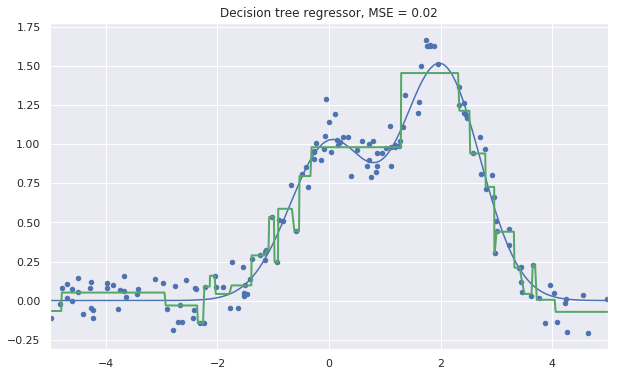

In [13]:
n_train = 150
n_test = 1000
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x**2)+1.5* np.exp(-(x-2)**2)


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth = 5, random_state = 17)
reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize = (10,6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c = 'b', s= 20)
plt.plot(X_test, reg_tree_pred, 'g', lw = 2)
plt.xlim([-5,5])
plt.title("Decision tree regressor, MSE = %.2f" % (np.sum((y_test -reg_tree_pred)**2)/ n_test))
plt.show()

In [14]:
df = pd.read_csv('../data/telecom_churn.csv')
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')
states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis = 1, inplace = True)

In [15]:
df.head()

Account length  Area code  International plan  Voice mail plan  \
0             128        415                   0                0   
1             107        415                   0                0   
2             137        415                   0                1   
3              84        408                   1                1   
4              75        415                   1                1   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   Total night minutes  Total night calls  Total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   Total intl minutes  Total intl calls  Total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   Customer service calls  
0                       1  
1                       1  
2                       0  
3                       2  
4                       3

In [16]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size = 0.3, random_state = 17)
tree = DecisionTreeClassifier(max_depth = 5, random_state = 17)
knn = KNeighborsClassifier(n_neighbors = 10)

tree.fit(X_train, y_train)

#For KNN, we need to scale features
scaler =StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [17]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.93999999999999995

In [18]:
knn_pred = knn.predict(X_holdout_scaled)
accuracy_score(y_holdout, knn_pred)

0.89000000000000001

In [19]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': range(1,11), 'max_features': range(4,19)}

tree_grid = GridSearchCV(tree, tree_params, cv = 5, n_jobs = -1, verbose = True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 115 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   13.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [20]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [21]:
tree_grid.best_score_

0.94256322331761677

In [22]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.94599999999999995

In [23]:
tree_graph_to_png(tree=tree_grid.best_estimator_, feature_names=df.columns,
                 png_file_to_save='../03_Decision_Trees/topic3_tree4.png')



In [24]:
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs = -1))])
knn_params = {'knn__n_neighbors': range(1,10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv = 5, n_jobs = -1, verbose = True)

knn_grid.fit(X_train, y_train)
knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.3s finished


({'knn__n_neighbors': 7}, 0.88598371195885128)

In [25]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89000000000000001

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 17) 
print(np.mean(cross_val_score(forest, X_train, y_train, cv = 5)))



0.949423311981


In [27]:
forest_params = {'max_depth': range(6,12), 'max_features': range(4,19)}

forest_grid = GridSearchCV(forest, forest_params, cv = 5, n_jobs = -1, verbose = True)
forest_grid.fit(X_train, y_train)


Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  8.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(6, 12), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [28]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 9, 'max_features': 6}, 0.95113587655379339)

In [29]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.95299999999999996

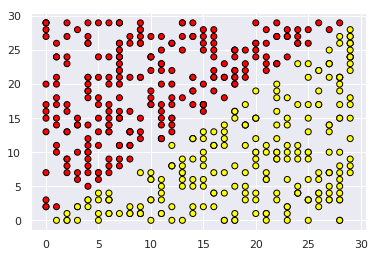

In [30]:
def form_linearly_separable_data(n= 500, x1_min = 0, x1_max = 30, x2_min = 0, x2_max = 30):
    data, target = [], []
    for i in range(n):
        x1 = np.random.randint(x1_min, x1_max)
        x2 = np.random.randint(x2_min, x2_max)
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1- x2))
    return np.array(data), np.array(target)
    
X, y = form_linearly_separable_data()

plt.scatter(X[:,0], X[:,1], c = y , cmap = 'autumn', edgecolors = 'black');
        
    

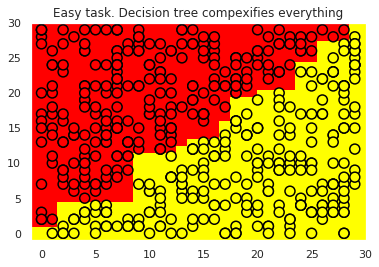

In [31]:
tree = DecisionTreeClassifier(random_state= 17).fit(X,y)

xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap = 'autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

In [32]:
tree_graph_to_png(tree=tree, feature_names=['x1', 'x2'],
         png_file_to_save='../03_Decision_Trees/topic3_tree5.png')



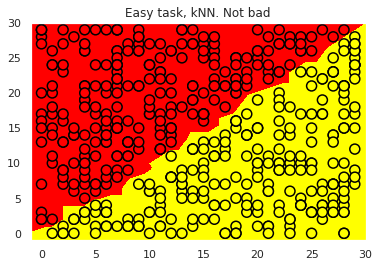

In [33]:
knn = KNeighborsClassifier(n_neighbors = 1).fit(X, y)

xx, yy = get_grid(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.title('Easy task, kNN. Not bad');

In [34]:
from sklearn.datasets import load_digits
data = load_digits()
X, y = data.data, data.target
X[0,:].reshape([8,8])

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]])

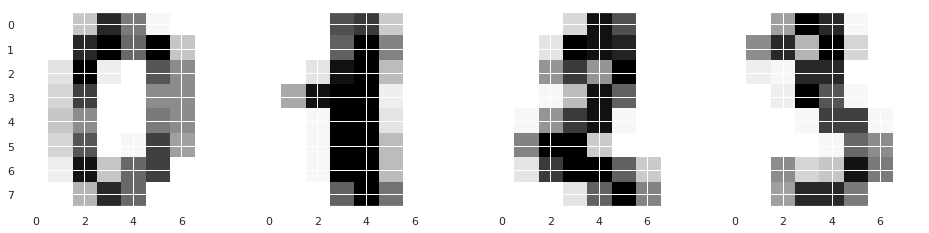

In [35]:
f, axes = plt.subplots(1,4, sharey = True, figsize = (16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]), cmap = 'Greys');

In [36]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.3, random_state = 17)

In [37]:
tree = DecisionTreeClassifier(max_depth = 5, random_state = 17)
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn',KNeighborsClassifier(n_neighbors = 10))])
tree.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform'))])

In [38]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn_pipe.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred)

(0.97592592592592597, 0.66666666666666663)

In [39]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
               'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

tree_grid = GridSearchCV(tree, tree_params, 
                         cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    7.3s finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64], 'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [40]:
tree_grid.best_params_, tree_grid.best_score_ 


({'max_depth': 20, 'max_features': 64}, 0.84407319013524262)

In [41]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors = 1), X_train, y_train, cv = 5))

0.98654584223971487

In [42]:
np.mean(cross_val_score(RandomForestClassifier(random_state =17), X_train, y_train, cv = 5))

0.93490856191104044

In [43]:
np.mean(cross_val_score(DecisionTreeClassifier(random_state = 17), X_train, y_train, cv = 5))

0.84425085282668066

In [44]:
np.mean(cross_val_score(GridSearchCV(tree, tree_params, 
                         cv=5, n_jobs=-1, verbose=True), X_train, y_train, cv = 5))

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    6.4s finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    4.2s finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    4.9s finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    5.1s finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    6.8s finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8325453036715349

In [46]:
def form_noisy_data(n_obj = 1000, n_feat = 100, random_seed = 17):
    np.seed = random_seed
    y = np.random.choice([-1,1], size = n_obj)
    
    #First eature is proportional to target
    x1=0.3 * y
    
    #Other feature are noise
    x_other= np.random.random(size = [n_obj, n_feat - 1])
    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y

X, y = form_noisy_data()
    

As always, we will look at the accuracy for cross-validation and the hold-out set. Let's construct curves reflecting the dependence of these quantities on the n_neighbors parameter in the method of nearest neighbors. These curves are called validation curves.

One can see that k-NN with the Euclidean distance does not work well on the problem, even when you vary the number of nearest neighbors over a wide range. In contrast, the decision tree easily "detects" hidden dependencies in the data despite a restriction on the maximum depth.


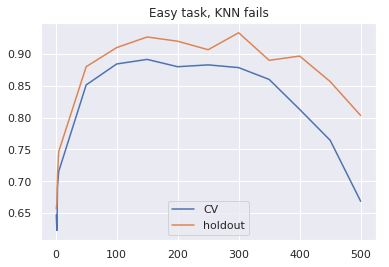

In [54]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.3, random_state = 17)

from sklearn.model_selection import cross_val_score
    
cv_scores, holdout_scores = [], []

n_neighb = [1,2,3,5] + list(range(50,550,50))

for k in n_neighb:
    
    knn_pipe = Pipeline([('scaler',  StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = k))])
    cv_scores.append(np.mean(cross_val_score(knn_pipe,X_train, y_train, cv = 5)))
    knn_pipe.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn_pipe.predict(X_holdout)))
    
plt.plot(n_neighb, cv_scores, label = 'CV')
plt.plot(n_neighb, holdout_scores, label = 'holdout')
plt.title("Easy task, KNN fails")
plt.legend();

In [56]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print('Decision tree. CV: {}, holdout: {}'.format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0
